In [43]:
import math
import jax
import jax.numpy as jnp
from jax import jit, value_and_grad, lax
import jax.scipy.linalg as jsp

import flax.linen as nn
from flax.training import train_state
import optax

import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


## Grid Setup and Linear Solver

This code cell defines functions for setting up the spatial and temporal grids for a 1D problem and for solving linear systems using Cholesky decomposition, which is a numerical method often used in solving discretized partial differential equations.

The `setup_grid` function discretizes a spatial domain $[0, 1]$ and a temporal domain $[0, T]$.

- The spatial domain is discretized into $N_x = nh-1$ interior points, with a spatial step size of $h = \frac{1}{nh}$. The interior grid points are $x_i = i h$ for $i = 1, \dots, N_x$.
- The temporal domain is discretized into $nk$ steps, with a temporal step size of $k = \frac{T}{nk}$. The time points are $t_j = j k$ for $j = 1, \dots, nk$.

The function constructs a matrix $A$ which arises from the finite difference discretization of a spatial second derivative term, combined with a term from the temporal discretization (like in an implicit Euler scheme). For a standard 1D diffusion term $\frac{\partial^2 u}{\partial x^2}$, the discretized operator on the interior points results in a tridiagonal matrix. The matrix $K_h$ represents this spatial discretization:

$K_h = \frac{1}{h^2} \begin{pmatrix}
2 & -1 & 0 & \dots \\
-1 & 2 & -1 & \dots \\
0 & -1 & 2 & \dots \\
\vdots & \vdots & \vdots & \ddots
\end{pmatrix}$

The matrix $A$ is then formed as $A = \frac{1}{k}I + K_h$, where $I$ is the identity matrix. This matrix $A$ is symmetric and positive definite, which allows for the use of the Cholesky decomposition.

The Cholesky decomposition of a symmetric positive definite matrix $A$ is $A = L L^T$, where $L$ is a lower triangular matrix. The `chol_solve` function solves the linear system $A u = b$ by first solving $L y = b$ for $y$ (forward substitution) and then solving $L^T u = y$ for $u$ (backward substitution).

In [44]:
def setup_grid(nh: int, nk: int, T: float = 1.0):
    """
    Returns a dict g with array leaves:
      g['x'] (Nx,), g['t'] (nk,), g['k'], g['h'], g['T'],
      g['Kh'] (Nx,Nx), g['A'] (Nx,Nx), g['L'] (chol of A)
    Dirichlet at x=0,1 ⇒ interior Nx = nh-1.
    """
    Nx = nh - 1
    h  = 1.0 / nh
    k  = T / nk
    x  = jnp.linspace(h, 1.0 - h, Nx)
    t  = jnp.linspace(k, T, nk)

    main =  2.0 / h**2 * jnp.ones((Nx,))
    off  = -1.0 / h**2 * jnp.ones((Nx-1,))
    Kh   = jnp.diag(main) + jnp.diag(off, 1) + jnp.diag(off, -1)

    A = (1.0 / k) * jnp.eye(Nx) + Kh
    L = jnp.linalg.cholesky(A)  # lower-triangular

    g = dict(nh=nh, nk=nk, Nx=Nx, T=T, h=h, k=k, x=x, t=t, Kh=Kh, A=A, L=L)
    return g

def chol_solve(L, b):
    """Solve A u = b given lower-triangular Cholesky L of A (A = L L^T)."""
    y = jsp.solve_triangular(L, b, lower=True)
    u = jsp.solve_triangular(L.T, y, lower=False)
    return u


## Synthetic Truth Generation

This code cell implements the `synth_truth_U` function, which generates synthetic "true" solutions to the partial differential equation based on known analytical solutions for specific forcing functions and boundary/initial conditions. This synthetic truth serves as the target data for training the neural networks.

The function supports different `truth_case` scenarios, each corresponding to a different analytical solution:

- **'oscillatory'**: The analytical solution is $u(x, t) = \sin(\pi x) \cos(\pi t)$. The corresponding forcing function $f(x, t)$ is derived by substituting $u(x,t)$ into the PDE:
  $$ \frac{\partial u}{\partial t} - \frac{\partial^2 u}{\partial x^2} = f(x, t) $$
  $$ \frac{\partial}{\partial t}(\sin(\pi x) \cos(\pi t)) - \frac{\partial^2}{\partial x^2}(\sin(\pi x) \cos(\pi t)) = f(x, t) $$
  $$ -\pi \sin(\pi x) \sin(\pi t) - (-\pi^2 \sin(\pi x) \cos(\pi t)) = f(x, t) $$
  $$ f(x, t) = \pi^2 \sin(\pi x) \cos(\pi t) - \pi \sin(\pi x) \sin(\pi t) $$
  The initial condition is $u(x, 0) = \sin(\pi x)$.

- **'decaying'**: The analytical solution is $u(x, t) = e^{-t} \sin(\pi x)$. The corresponding forcing function $f(x, t)$ is derived similarly:
  $$ \frac{\partial}{\partial t}(e^{-t} \sin(\pi x)) - \frac{\partial^2}{\partial x^2}(e^{-t} \sin(\pi x)) = f(x, t) $$
  $$ -e^{-t} \sin(\pi x) - (- \pi^2 e^{-t} \sin(\pi x)) = f(x, t) $$
  $$ f(x, t) = (\pi^2 - 1) e^{-t} \sin(\pi x) $$
  The initial condition is $u(x, 0) = \sin(\pi x)$.

The function then uses the `lax.scan` operation to simulate the time evolution of the solution. Starting from the true initial condition $u_0$, it iteratively solves the linear system $A u_{n+1} = \frac{1}{k} u_n + f_{n+1}$ at each time step $t_{n+1}$, where $f_{n+1}$ is the true forcing function at that time. This process generates the synthetic truth solution $U_{true}$ over all time steps.

In [45]:
def synth_truth_U(g, truth_case='oscillatory'):
    """
    Generates synthetic truth U based on different analytical solutions.

    Args:
        g: Dictionary containing grid information.
        truth_case: String specifying the synthetic truth case.
                    'oscillatory': u(x,t) = sin(pi x) cos(pi t)
                    'decaying': u(x,t) = exp(-t) * sin(pi x)

    Returns:
        U: (nk,Nx) array of the synthetic truth solution.
        u0_true: (Nx,) array of the true initial condition.
    """
    x, t, k = g['x'], g['t'], g['k']

    if truth_case == 'oscillatory':
        u0_true = jnp.sin(jnp.pi * x)
        def f_true_t(tval):
            return (-jnp.pi * jnp.sin(jnp.pi * tval) + (jnp.pi**2) * jnp.cos(jnp.pi * tval)) * jnp.sin(jnp.pi * x)
    elif truth_case == 'decaying':
        u0_true = jnp.sin(jnp.pi * x)
        def f_true_t(tval):
            return (jnp.pi**2 - 1.0) * jnp.exp(-tval) * jnp.sin(jnp.pi * x)
    else:
        raise ValueError(f"Unknown truth_case: {truth_case}")


    def step(u_prev, t_now):
        f_now = f_true_t(t_now)
        rhs   = u_prev / k + f_now
        u_next = chol_solve(g['L'], rhs)
        return u_next, u_next

    U = lax.scan(step, u0_true, t)[1]  # (nk,Nx)
    return U, u0_true

## Neural Network Models and Training State

This code cell defines the neural network architectures used to model the forcing function $f(x,t)$ and the initial condition $u_0(x)$, and sets up the training state using Flax and Optax.

- **MLP2x256Tanh**: This is a basic Multi-Layer Perceptron (MLP) with two hidden layers, each having 256 neurons, and using the hyperbolic tangent (`tanh`) activation function. It serves as a building block for the other networks. The output layer has a tiny initialization scale and zero bias initialization.

- **ForcingNet**: This module wraps the `MLP2x256Tanh` to take a 2-dimensional input $(x, t)$ and output a scalar value representing the predicted forcing function $f(x, t)$. The input coordinates $x$ and $t$ are expected to be normalized, typically to the range $[-1, 1]$.

- **ICNet**: This module wraps the `MLP2x256Tanh` to take a 1-dimensional input $(x)$ and output a scalar value representing the predicted initial condition $u_0(x)$. The input coordinate $x$ is expected to be normalized.

- **TrainState**: This is a standard Flax utility class extended to hold the model's parameters, the optimizer state, and the current training step.

The `create_state` function initializes the model parameters using a provided PRNG key and sets up the Optax optimizer with a learning rate schedule. An exponential decay schedule is used for the learning rate, starting with `lr` and decaying by a factor of 0.9 over the specified number of `epochs`. Gradient clipping with a global norm of 1.0 is also applied.

In [46]:
def tiny_init(scale=1e-3):
    def init(rng, shape, dtype=jnp.float64):
        return scale * jax.random.normal(rng, shape, dtype)
    return init

class MLP2x256Tanh(nn.Module):
    in_dim: int
    out_dim: int
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256)(x); x = nn.tanh(x)
        x = nn.Dense(256)(x); x = nn.tanh(x)
        x = nn.Dense(self.out_dim, kernel_init=tiny_init(1e-3), bias_init=nn.initializers.zeros)(x)
        return x

class ForcingNet(nn.Module):   # (x,t) -> f
    @nn.compact
    def __call__(self, xt):
        return MLP2x256Tanh(in_dim=2, out_dim=1)(xt).squeeze(-1)

class ICNet(nn.Module):        # x -> u0
    @nn.compact
    def __call__(self, x):
        return MLP2x256Tanh(in_dim=1, out_dim=1)(x).squeeze(-1)

class TrainState(train_state.TrainState):
    pass

def create_state(rng, model, in_dim, lr, epochs, learn_ic: bool = False):
    dummy = jnp.zeros((1, in_dim))
    params = model.init(rng, dummy)

    # Add a learning rate schedule
    lr_schedule = optax.exponential_decay(
        init_value=lr,
        transition_steps=epochs, # Decay over the total number of epochs
        decay_rate=0.9 # Decay rate
    )

    tx = optax.chain(
        optax.clip_by_global_norm(1.0),  # grad clip
        optax.adam(lr_schedule) # Use the learning rate schedule
    )

    # Conditionally create the TrainState for the ICNet
    if learn_ic:
        return TrainState(step=0, apply_fn=model.apply, params=params, tx=tx, opt_state=tx.init(params))
    else:
        return None # Return None for state_u if not learning IC

## Forward Pass with Neural Networks

This code cell implements the `forward_with_nn` function, which performs the forward pass of the neural network model. This involves using the trained (or currently training) `ForcingNet` and optionally the `ICNet` to predict the forcing function $f(x,t)$ and the initial condition $u_0(x)$, respectively. The `learn_ic` parameter controls whether the `ICNet` is used or if the initial condition is fixed to zero.

The process is as follows:
1. **Input Normalization**: The spatial grid points $x$ and temporal grid points $t$ are normalized to the range $[-1, 1]$. This is a common practice for improving neural network training.
2. **Initial Condition Prediction/Setting**: If `learn_ic` is True, the `ICNet` predicts the initial condition $u_0^{pred}(x)$ at the spatial grid points. If `learn_ic` is False, the initial condition $u_0^{pred}(x)$ is fixed to zero for all spatial points.
3. **Time Evolution Simulation**: Similar to the `synth_truth_U` function, `lax.scan` is used to simulate the time evolution of the PDE solution. The `ForcingNet` predicts the forcing $f^{pred}(x, t)$ at each time step $t_n$ and spatial location $x_i$.
4. **Solving the Linear System**: At each time step $t_n$, the predicted initial condition $u_n^{pred}$ from the previous step and the predicted forcing $f^{pred}(x, t_n)$ are used to form the right-hand side of the linear system:
$$ A u_{n+1}^{pred} = \frac{1}{k} u_n^{pred} + f^{pred}(x, t_{n+1}) $$
This system is solved for $u_{n+1}^{pred}$ using the `chol_solve` function.
5. **Output**: The function returns the predicted solution $U^{pred}(x, t)$ over all time steps and spatial points, the predicted forcing function $F^{pred}(x, t)$, and the predicted initial condition $u_0^{pred}(x)$ (which will be zero if `learn_ic` is False).

In [53]:
def forward_with_nn(state_f: TrainState, state_u: TrainState | None, g: dict, u0_true: jnp.ndarray, learn_ic: bool = True):
    """
    Performs the forward pass with neural networks, with an option to fix the initial condition to u0_true.

    Args:
        state_f: Training state for the ForcingNet.
        state_u: Training state for the ICNet, or None if learn_ic is False.
        g: Dictionary containing grid information.
        u0_true: The true initial condition (Nx,) array. Used when learn_ic is False.
        learn_ic: Boolean flag, if True, learns the initial condition with ICNet.
                  If False, fixes the initial condition to u0_true.

    Returns:
      U_pred: (nk,Nx), F_pred: (nk,Nx), u0_pred: (Nx,)
    """
    # normalize to [-1,1]
    x_norm = 2.0 * g['x'] - 1.0              # (Nx,)
    t_norm = 2.0 * g['t'] / g['T'] - 1.0     # (nk,)

    # Conditionally determine the initial condition
    if learn_ic:
        # Ensure state_u is not None when learning IC
        assert state_u is not None, "state_u cannot be None when learn_ic is True"
        u0_pred = state_u.apply_fn(state_u.params, x_norm[:, None]).squeeze(-1)  # (Nx,)
    else:
        u0_pred = u0_true # Use the true initial condition when learn_ic is False

    def step(u_prev, t_n):
        xt = jnp.stack([x_norm, jnp.full_like(x_norm, t_n)], axis=1)  # (Nx,2)
        f_n_with_dim = state_f.apply_fn(state_f.params, xt)            # (Nx,1)
        f_n = f_n_with_dim                             # (Nx,)
        rhs = u_prev / g['k'] + f_n
        u_next = chol_solve(g['L'], rhs)
        return u_next, (u_next, f_n)

    _, (U_seq, F_seq) = lax.scan(step, u0_pred, t_norm)  # (nk,Nx), (nk,Nx)
    return U_seq, F_seq, u0_pred

## Loss Function
This code cell defines the `compute_loss` function, which calculates the objective function minimized during training. The total loss $L$ is a sum of several terms:

$$ L = L_{misfit} + L_{regF} + L_{regIC} + L_{smooth} $$

1.  **Misfit Loss ($L_{misfit}$)**: Measures how well the predicted solution ($U^{pred}$) matches the true data ($U_{true}$). It's the mean squared error: $L_{misfit} = \text{mean}((U^{pred} - U_{true})^2)$.
2.  **Forcing Regularization ($L_{regF}$)**: Penalizes the magnitude of the predicted forcing function ($F^{pred}$). It's an L2 penalty: $L_{regF} = \alpha \cdot \text{mean}((F^{pred})^2)$.
3.  **Initial Condition Regularization ($L_{regIC}$)**: Penalizes the magnitude of the predicted initial condition ($u_0^{pred}$). It's an L2 penalty: $L_{regIC} = \beta_{ic} \cdot \text{mean}((u_0^{pred})^2)$. **Note:** This term is only included in the total loss if the `learn_ic` flag is set to True in the training setup; otherwise, it is zero.
4.  **Smoothness Regularization ($L_{smooth}$)**: Encourages the predicted forcing function ($F^{pred}$) to be smooth in space ($x$) and time ($t$). This includes penalties on spatial differences ($L_{smooth,x}$) and temporal differences ($L_{smooth,t}$), weighted by $\gamma_x$ and $\gamma_t$ respectively.

The function returns the total loss $L$ and a dictionary `metrics` with the values of each component.

In [54]:
def compute_loss(state_f: TrainState, state_u: TrainState | None, g: dict, U_true: jnp.ndarray, hp: dict, u0_true: jnp.ndarray, learn_ic: bool = True):
    """
    hp = {'alpha': ..., 'beta_ic': ..., 'gamma_x': ..., 'gamma_t': ...}  # jnp scalars
    """
    U_pred, F_pred, u0_pred = forward_with_nn(state_f, state_u, g, u0_true, learn_ic=learn_ic)

    Nu = U_true.size
    misfit = jnp.sum((U_pred - U_true)**2) / Nu
    regF   = hp['alpha']   * jnp.mean(F_pred**2)

    # Conditionally include regIC based on learn_ic
    regIC = lax.cond(learn_ic,
                     lambda _: hp['beta_ic'] * jnp.mean(u0_pred**2),
                     lambda _: jnp.array(0.0, dtype=jnp.float64),
                     None)

    smooth_x = lax.cond(hp['gamma_x'] > 0,
                        lambda _: hp['gamma_x'] * jnp.mean((F_pred[:, 1:] - F_pred[:, :-1])**2),
                        lambda _: jnp.array(0.0, dtype=jnp.float64),
                        None)

    smooth_t = lax.cond(hp['gamma_t'] > 0,
                        lambda _: hp['gamma_t'] * jnp.mean((F_pred[1:, :] - F_pred[:-1, :])**2),
                        lambda _: jnp.array(0.0, dtype=jnp.float64),
                        None)

    smooth = smooth_x + smooth_t

    loss = misfit + regF + regIC + smooth
    metrics = dict(misfit=misfit, regF=regF, regIC=regIC, smooth=smooth)
    return loss, metrics

## Training Setup

This code cell sets up all the necessary components before starting the training loop. Note: the `learn_ic` boolean represents whether or not we want to learn the initial condition using the `ICNet` or assume it as part of the problem setup (specifically, fixed to zero in this implementation).

1. **Grid Definition**: The spatial and temporal grid parameters (`nh`, `nk`, `T`) are defined, matching the setup used in the original paper or desired configuration. The `setup_grid` function is called to create the grid dictionary `g` containing grid points, step sizes, and the matrix $A$ and its Cholesky decomposition $L$.
2. **Synthetic Truth Generation**: The `synth_truth_U` function is used to generate the synthetic "true" solution $U_{true}$ and initial condition $u_{0,true}$. This serves as the target data for training. The `truth_case` parameter determines which analytical solution is used ('oscillatory' or 'decaying'). In a real-world scenario, $U_{true}$ would be replaced by your observed data.
3. **Model and State Initialization**: JAX PRNG keys are created for reproducibility. Instances of the `ForcingNet` and `ICNet` models are created. The `create_state` function is called for each model to initialize their parameters, set up the Optax optimizer with the specified learning rate (`lr`) and number of epochs, and create the `TrainState` objects (`state_f` and `state_u`). The `learn_ic` flag is passed to `create_state` to conditionally initialize the `ICNet` state (`state_u`).
4. **Hyperparameter Definition**: A dictionary `hp` is created to store the hyperparameters for the loss function. These hyperparameters control the weighting of the regularization terms ($\alpha$, $\beta_{ic}$, $\gamma_x$, $\gamma_t$). They are explicitly cast to JAX arrays (`jnp.array`) to ensure they are treated as JAX PyTrees, compatible with JIT compilation and automatic differentiation.

In [49]:
@jit
def train_step(state_f: TrainState, state_u: TrainState | None, g: dict, U_true: jnp.ndarray, hp: dict, learn_ic: bool = True):
    # Define the loss function for gradient calculation
    def loss_fn(params_f, params_u):
        # Recreate states with current params
        current_state_f = state_f.replace(params=params_f)
        current_state_u = state_u.replace(params=params_u) if state_u is not None else None
        return compute_loss(current_state_f, current_state_u, g, U_true, hp, learn_ic=learn_ic)

    if learn_ic:
        # Compute gradients for both state_f and state_u
        (L, M), grads = value_and_grad(loss_fn, argnums=(0, 1), has_aux=True)(state_f.params, state_u.params)

        # Apply updates for both states
        updates_f, opt_state_f = state_f.tx.update(grads[0], state_f.opt_state, state_f.params)
        updates_u, opt_state_u = state_u.tx.update(grads[1], state_u.opt_state, state_u.params)

        new_state_f = state_f.replace(step=state_f.step+1,
                                      params=optax.apply_updates(state_f.params, updates_f),
                                      opt_state=opt_state_f)
        new_state_u = state_u.replace(step=state_u.step+1,
                                      params=optax.apply_updates(state_u.params, updates_u),
                                      opt_state=opt_state_u)
    else:
        # Compute gradients only for state_f
        (L, M), grads = value_and_grad(lambda params_f: loss_fn(params_f, None), argnums=0, has_aux=True)(state_f.params)

        # Apply updates only for state_f
        updates_f, opt_state_f = state_f.tx.update(grads, state_f.opt_state, state_f.params)

        new_state_f = state_f.replace(step=state_f.step+1,
                                      params=optax.apply_updates(state_f.params, updates_f),
                                      opt_state=opt_state_f)
        # state_u remains unchanged
        new_state_u = state_u # state_u should be None in this case anyway

    return new_state_f, new_state_u, L, M



In [55]:
# Remove the @jit decorator
def train_step(state_f: TrainState, state_u: TrainState | None, g: dict, U_true: jnp.ndarray, hp: dict, u0_true: jnp.ndarray, learn_ic: bool = True):
    # Define the loss function for gradient calculation
    def loss_fn(params_f, params_u):
        # Recreate states with current params
        current_state_f = state_f.replace(params=params_f)
        current_state_u = state_u.replace(params=params_u) if state_u is not None else None
        return compute_loss(current_state_f, current_state_u, g, U_true, hp, u0_true, learn_ic=learn_ic)

    if learn_ic:
        # Compute gradients for both state_f and state_u
        (L, M), grads = value_and_grad(loss_fn, argnums=(0, 1), has_aux=True)(state_f.params, state_u.params)

        # Apply updates for both states
        updates_f, opt_state_f = state_f.tx.update(grads[0], state_f.opt_state, state_f.params)
        updates_u, opt_state_u = state_u.tx.update(grads[1], state_u.opt_state, state_u.params)

        new_state_f = state_f.replace(step=state_f.step+1,
                                      params=optax.apply_updates(state_f.params, updates_f),
                                      opt_state=opt_state_f)
        new_state_u = state_u.replace(step=state_u.step+1,
                                      params=optax.apply_updates(state_u.params, updates_u),
                                      opt_state=opt_state_u)
    else:
        # Compute gradients only for state_f
        (L, M), grads = value_and_grad(lambda params_f: loss_fn(params_f, None), argnums=0, has_aux=True)(state_f.params)

        # Apply updates only for state_f
        updates_f, opt_state_f = state_f.tx.update(grads, state_f.opt_state, state_f.params)

        new_state_f = state_f.replace(step=state_f.step+1,
                                      params=optax.apply_updates(state_f.params, updates_f),
                                      opt_state=opt_state_f)
        # state_u remains unchanged
        new_state_u = state_u # state_u should be None in this case anyway

    return new_state_f, new_state_u, L, M

# Define JIT-compiled wrappers
@jit # g is the 3rd argument (index 2)
def train_step_learn_ic(state_f: TrainState, state_u: TrainState, g: dict, U_true: jnp.ndarray, hp: dict):
    # Note: u0_true is not passed here, as it's not used when learn_ic=True
    return train_step(state_f, state_u, g, U_true, hp, None, learn_ic=True) # Pass None for u0_true when learning IC

@jit # g is the 3rd argument (index 2), u0_true is the 4th argument (index 3)
def train_step_fixed_ic(state_f: TrainState, state_u: None, g: dict, U_true: jnp.ndarray, hp: dict, u0_true: jnp.ndarray):
    return train_step(state_f, state_u, g, U_true, hp, u0_true, learn_ic=False)

## Training Setup

This code cell sets up all the necessary components before starting the training loop. Note: the `learn_ic` boolean represents whether or not we want to learn the ic or assume it as part of the problem setup.

1. **Grid Definition**: The spatial and temporal grid parameters (`nh`, `nk`, `T`) are defined, matching the setup used in the original paper or desired configuration. The `setup_grid` function is called to create the grid dictionary `g` containing grid points, step sizes, and the matrix $A$ and its Cholesky decomposition $L$.

2. **Synthetic Truth Generation**: The `synth_truth_U` function is used to generate the synthetic "true" solution $U_{true}$ and initial condition $u_{0,true}$. This serves as the target data for training. The `truth_case` parameter determines which analytical solution is used ('oscillatory' or 'decaying'). In a real-world scenario, $U_{true}$ would be replaced by your observed data.

3. **Model and State Initialization**: JAX PRNG keys are created for reproducibility. Instances of the `ForcingNet` and `ICNet` models are created. The `create_state` function is called for each model to initialize their parameters, set up the Optax optimizer with the specified learning rate (`lr`) and number of epochs, and create the `TrainState` objects (`state_f` and `state_u`).

4. **Hyperparameter Definition**: A dictionary `hp` is created to store the hyperparameters for the loss function. These hyperparameters control the weighting of the regularization terms ($\alpha$, $\beta_{ic}$, $\gamma_x$, $\gamma_t$). They are explicitly cast to JAX arrays (`jnp.array`) to ensure they are treated as JAX PyTrees, compatible with JIT compilation and automatic differentiation.

In [51]:
# Grid like the paper
nh, nk, T = 150, 50, 1.0
g = setup_grid(nh, nk, T)

# Synthetic target (replace U_true with your measured data, shape (nk,Nx), if available)
# U_true, u0_true = synth_truth_U(g, truth_case='oscillatory') # Original oscillatory case
U_true, u0_true = synth_truth_U(g, truth_case='decaying') # New decaying case

# Option to learn the initial condition or fix it to zero
learn_ic = False # Set to True to learn the IC, False to fix it to zero

# Models & states
key = jax.random.PRNGKey(0)
k1, k2, k3 = jax.random.split(key, 3) # Split key for potential conditional use in create_state
forcing_net = ForcingNet()
ic_net      = ICNet()

# Pass learn_ic to create_state
state_f = create_state(k1, forcing_net, in_dim=2, lr=3e-3, epochs=1000, learn_ic=True) # Forcing net is always learned
state_u = create_state(k2, ic_net,      in_dim=1, lr=3e-3, epochs=1000, learn_ic=learn_ic) # Conditionally create IC state


# Hyperparameters as JAX scalars (PyTree-friendly)
hp = {
    'alpha'  : jnp.array(1e-3),  # control magnitude penalty (MSE-scaled)
    'beta_ic': jnp.array(1e-4),  # small prior on u0
    'gamma_x': jnp.array(1e-4),  # smoothness in x (set 0 to disable)
    'gamma_t': jnp.array(1e-4),  # smoothness in t (set 0 to disable)
}

## Training Loop

This code cell implements the main training loop. It iterates for a fixed number of `epochs`, performing a training step in each iteration.

In each epoch:
1. The `train_step` function is called with the current training states (`state_f`, `state_u`), the grid information (`g`), the true solution data (`U_true`), and the hyperparameters (`hp`).
2. `train_step` computes the loss and gradients, updates the model parameters using the optimizer, and returns the updated states, the total loss ($L$), and the metrics dictionary ($M$).
3. The updated states are assigned back to `state_f` and `state_u`.
4. The loss and metric values are optionally printed every 50 epochs to monitor training progress.
5. The loss and metric values are appended to the `hist` dictionary to keep a record of the training history.

This iterative process allows the model parameters to be adjusted based on the gradients of the loss function, gradually minimizing the difference between the predicted and true solutions while satisfying the regularization constraints.

In [56]:
epochs = 2000 # Increased epochs to match create_state
hist = dict(L=[], misfit=[], regF=[], regIC=[], smooth=[])

for ep in range(epochs):
    # Call the appropriate JIT-compiled train step based on learn_ic
    if learn_ic:
        state_f, state_u, L, M = train_step_learn_ic(state_f, state_u, g, U_true, hp)
    else:
        state_f, state_u, L, M = train_step_fixed_ic(state_f, state_u, g, U_true, hp, u0_true) # Pass u0_true here


    if ep % 50 == 0:
        print(f"ep {ep:4d} | L={float(L):.6f} | mis={float(M['misfit']):.6f} | "
              f"regF={float(M['regF']):.6f} | regIC={float(M['regIC']):.6f} | sm={float(M['smooth']):.6f}") # Added regIC print
    hist['L'].append(float(L))
    for k in ('misfit','regF','regIC','smooth'):
        hist[k].append(float(M[k]))

ep    0 | L=0.142630 | mis=0.135391 | regF=0.007236 | regIC=0.000000 | sm=0.000003
ep   50 | L=0.015576 | mis=0.002478 | regF=0.013097 | regIC=0.000000 | sm=0.000001
ep  100 | L=0.015256 | mis=0.001712 | regF=0.013543 | regIC=0.000000 | sm=0.000001
ep  150 | L=0.015183 | mis=0.001650 | regF=0.013531 | regIC=0.000000 | sm=0.000001
ep  200 | L=0.015155 | mis=0.001644 | regF=0.013510 | regIC=0.000000 | sm=0.000001
ep  250 | L=0.015135 | mis=0.001637 | regF=0.013497 | regIC=0.000000 | sm=0.000001
ep  300 | L=0.015119 | mis=0.001631 | regF=0.013487 | regIC=0.000000 | sm=0.000001
ep  350 | L=0.015105 | mis=0.001626 | regF=0.013478 | regIC=0.000000 | sm=0.000001
ep  400 | L=0.015091 | mis=0.001622 | regF=0.013469 | regIC=0.000000 | sm=0.000001
ep  450 | L=0.015079 | mis=0.001619 | regF=0.013459 | regIC=0.000000 | sm=0.000001
ep  500 | L=0.015066 | mis=0.001617 | regF=0.013449 | regIC=0.000000 | sm=0.000001
ep  550 | L=0.015054 | mis=0.001615 | regF=0.013439 | regIC=0.000000 | sm=0.000001
ep  

## Evaluation and Plotting

This code cell performs evaluation of the trained model and visualizes the results.

1. **Forward Pass with Trained Nets**: The `forward_with_nn` function is called one last time using the final trained parameters (`state_f`, `state_u`) to obtain the predicted solution ($U_{pred}$), predicted forcing ($F_{pred}$), and predicted initial condition ($u_{0,pred}$).

2. **Error Calculation**: Various error metrics are calculated to quantify the performance of the trained model:
   - Absolute error: The L2 norm of the difference between the predicted and true solutions: $||U_{pred} - U_{true}||_2$.
   - Relative error: The absolute error normalized by the L2 norm of the true solution: $\frac{||U_{pred} - U_{true}||_2}{||U_{true}||_2}$. This gives a percentage error relative to the magnitude of the true solution.
   - Initial condition error: The L2 norm of the difference between the predicted and true initial conditions: $||u_{0,pred} - u_{0,true}||_2$.

3. **Plotting Loss Curves**: The training history stored in the `hist` dictionary is used to plot the evolution of the total loss and its components (misfit, forcing regularization, smoothness) over the training epochs. A semi-logarithmic scale is used for the y-axis to better visualize the decrease in loss, especially the smaller components.

4. **Plotting Recovered Trajectory**: The true and predicted solutions are plotted over time at a specific spatial location (here, $x=0.5$). This allows for a visual comparison of how well the model has captured the temporal dynamics of the solution at a representative point in the domain.

These evaluation steps provide both quantitative error measures and qualitative visualizations to assess the effectiveness of the training process and the performance of the learned neural network models.


Abs error: 3.483818e+00 | Rel: 8.73% | ||fixed_u0 - u0_true||=0.000000e+00


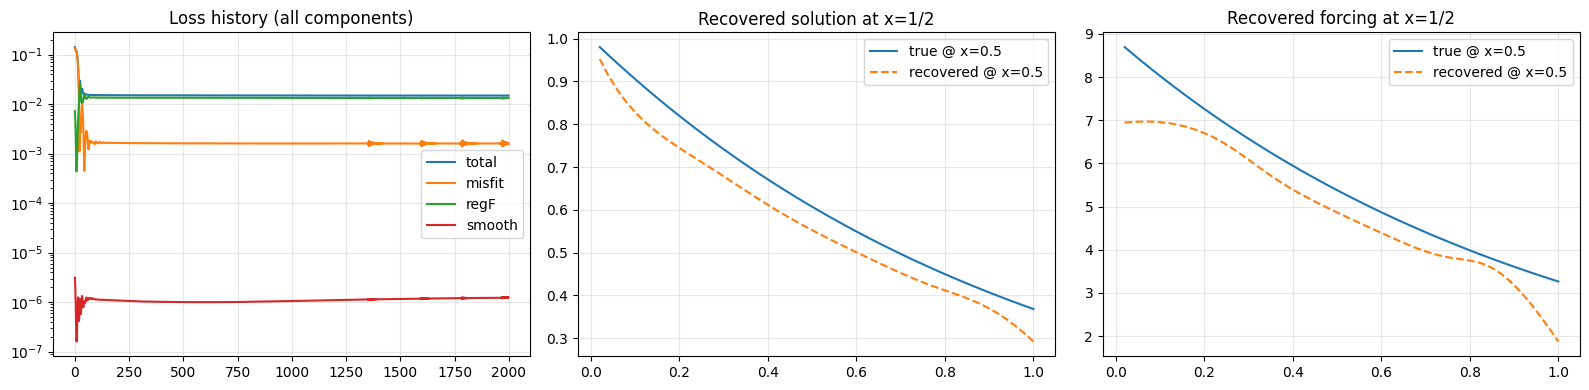

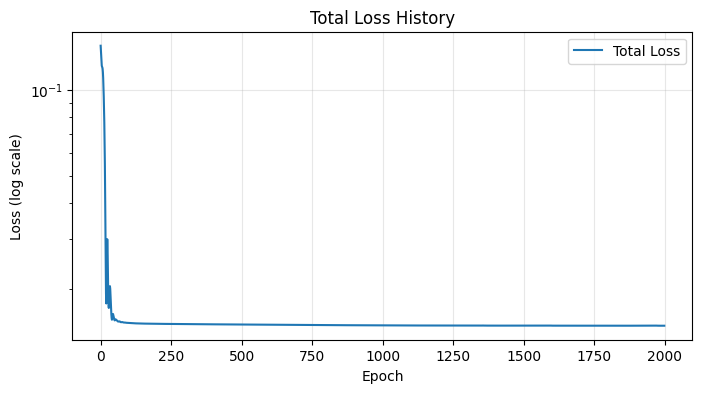

In [59]:
# Forward pass with trained nets
# Pass learn_ic and u0_true to forward_with_nn for evaluation
U_pred, F_pred, u0_pred = forward_with_nn(state_f, state_u, g, u0_true, learn_ic=learn_ic)

# Errors
abs_err = float(jnp.linalg.norm(U_pred - U_true))
rel_err = abs_err / float(jnp.linalg.norm(U_true))
# Only calculate ic_err if IC was learned
if learn_ic:
    ic_err  = float(jnp.linalg.norm(u0_pred - u0_true))
    print(f"\nAbs error: {abs_err:.6e} | Rel: {100*rel_err:.2f}% | ||u0_pred - u0_true||={ic_err:.6e}")
else:
    # If IC was fixed to u0_true, the error should be zero (ignoring float precision)
    # We can still report the difference between the predicted (fixed) u0 and the true u0
    ic_err  = float(jnp.linalg.norm(u0_pred - u0_true)) # u0_pred is now u0_true when learn_ic is False
    print(f"\nAbs error: {abs_err:.6e} | Rel: {100*rel_err:.2f}% | ||fixed_u0 - u0_true||={ic_err:.6e}")


# Plot loss curves (all components)
plt.figure(figsize=(16,4)) # Increased figure width for new subplot
plt.subplot(1,3,1) # Changed to 1 row, 3 columns, 1st plot
plt.semilogy(hist['L'], label='total')
plt.semilogy(hist['misfit'], label='misfit')
plt.semilogy(hist['regF'], label='regF')
if learn_ic: # Only plot regIC if it was included in the loss
    plt.semilogy(hist['regIC'], label='regIC')
plt.semilogy(hist['smooth'], label='smooth')
plt.legend(); plt.grid(True, alpha=0.3); plt.title("Loss history (all components)")

# Plot recovered trajectory at x = 1/2
ix = int(jnp.argmin(jnp.abs(g['x'] - 0.5)))
plt.subplot(1,3,2) # Changed to 1 row, 3 columns, 2nd plot
plt.plot(g['t'], U_true[:, ix], label='true @ x=0.5')
plt.plot(g['t'], U_pred[:, ix], '--', label='recovered @ x=0.5')
plt.legend(); plt.grid(True, alpha=0.3); plt.title("Recovered solution at x=1/2")

# Plot recovered forcing at x = 1/2
plt.subplot(1,3,3) # Added 3rd plot
# Need to generate the true forcing function sequence
# Reusing the function defined earlier for solver debugging
def get_true_forcing_func(g, truth_case='decaying'):
    x = g['x']
    if truth_case == 'oscillatory':
        def f_true_t(tval):
            return (-jnp.pi * jnp.sin(jnp.pi * tval) + (jnp.pi**2) * jnp.cos(jnp.pi * tval)) * jnp.sin(jnp.pi * x)
    elif truth_case == 'decaying':
        def f_true_t(tval):
            return (jnp.pi**2 - 1.0) * jnp.exp(-tval) * jnp.sin(jnp.pi * x)
    else:
         raise ValueError(f"Unknown truth_case: {truth_case}")
    return f_true_t

current_truth_case = 'decaying' # Hardcoded - ideally should be passed or stored

f_true_func = get_true_forcing_func(g, truth_case=current_truth_case)
F_true_seq = jax.vmap(f_true_func)(g['t']) # (nk, Nx)

plt.plot(g['t'], F_true_seq[:, ix], label='true @ x=0.5')
plt.plot(g['t'], F_pred[:, ix], '--', label='recovered @ x=0.5')
plt.legend(); plt.grid(True, alpha=0.3); plt.title("Recovered forcing at x=1/2")


plt.tight_layout(); plt.show()

# New plot for total loss only
plt.figure(figsize=(8, 4))
plt.semilogy(hist['L'], label='Total Loss')
plt.legend(); plt.grid(True, alpha=0.3); plt.title("Total Loss History")
plt.xlabel("Epoch"); plt.ylabel("Loss (log scale)")
plt.show()